In [ ]:
# set default parameters
# load relevant libraries

knitr::opts_chunk$set(
  	echo = TRUE,
  	error = FALSE,
  	fig.align = "centre",
  	fig.asp = 0.65,
  	fig.width = 10,
  	message = FALSE,
  	warning = FALSE)

library(plyr)
library(tidyverse)
library(ROCR)
library(rpart)
library(party)
library(hms)
library(scales)
library(ROSE)
library(class)
library(grDevices)
library(fpc)
library(reshape2)
library(grid)
library(gridExtra)
library(NbClust)
library(factoextra)

options(repr.plot.width=9, repr.plot.height=5.5)

___
# Australian Road Deaths
## Modelling
### Johnny Barrett & Daniel Chegwidden
___

# Introduction
This analysis will explore Australian road fatatilites from 1989 - 2019, utilising data sets provided by the Australian Government’s Australian Road Deaths Database (ARDD).

There are two datasets, one where each observation is an individual fatality, and one where each observation is a crash involving one or more fatalities. For the purposes of our modelling, we will focus on the 'Fatalities' data set, and draw observations from the 'Crashes' data set if necessary.

In this analysis, we aim to uncover patterns and relationships in the data, and form models that allow us to better understand variables of interest. This notebook will be divided into two core sections:

#### 1. Classification
For our classification task, we aim to develop models that help us explain the gender of a fatality on Australian roads. The modelling techniques used are:

* Single variable models
* Binary logistic regression
* Decision trees

#### 2. Clustering
Clustering analysis is an unsupervised method that helps us to see relationships between observations in our data. For this task, we use the Heirarchical Clustering method to explore similarities and differences between differently aged road users of differing types (eg. Motorcyclist, Car Passenger), according to the speed and time of the accident.

___
# Data Import / Transformation
This data is publicy available from https://www.data.gov.au/, and updated monthly:

In [ ]:
fatalities <- read_csv("https://data.gov.au/data/dataset/5b530fb8-526e-4fbf-b0f6-aa24e84e4277/resource/fd646fdc-7788-4bea-a736-e4aeb0dd09a8/download/ardd_fatalities.csv", na = c("-9", ""))

crashes <- read_csv("https://data.gov.au/data/dataset/5b530fb8-526e-4fbf-b0f6-aa24e84e4277/resource/d54f7465-74b8-4fff-8653-37e724d0ebbb/download/bitre_ardd_fatal_crashes.csv", na = c("-9", ""))

Before we begin modelling, some care needs to be taken with the handling of different variables within the data. From previous exploratory data analysis performed on this data, we know that some variables contain large proportions of missing values, providing inconsistent and limited value. We will drop these variables, and filter out the small number of observations where:

* `Gender` is not equal to Male or Female,
* A value for `Age` is missing,
* A value for `Time` is missing,
* A value for `Bus Involvement` is missing, 

as there are so few observations meeting these criteria and they are key data points for our modelling.

In [4]:
drop_col <- c("National Remoteness Areas", "SA4 Name 2016", 
              "National LGA Name 2017", "National Road Type")

df <- fatalities %>%
    select(-drop_col) %>%
    filter(Gender != "Unspecified") %>%
    filter(!is.na(Age), !is.na(Time), !is.na(`Bus Involvement`)) %>%
    mutate_all(funs(replace_na(., "Missing"))) %>%
    rename(H.Truck.Involvement = `Heavy Rigid Truck Involvement`,
           A.Truck.Involvement = `Articulated Truck Involvement`) %>% 
    as.data.frame()

colnames(df) <- str_replace_all(colnames(df), c(" " = "."), ("\n" = "."))  # standardise column names
df$Road.User <- revalue(df$Road.User, c("Other/-9" = "Other"))

df <- droplevels.data.frame(df) # dropping vacant levels

We also notice that for about 40% of our data, we don't have entries for `H.Truck.Involvement`:

In [5]:
paste0(round(sum(df$H.Truck.Involvement == "Missing") / nrow(df) * 100, 2), "%")

[1] "40.17%"

We will take a look to see how data for this variable is distributed across the years the data was recorded:

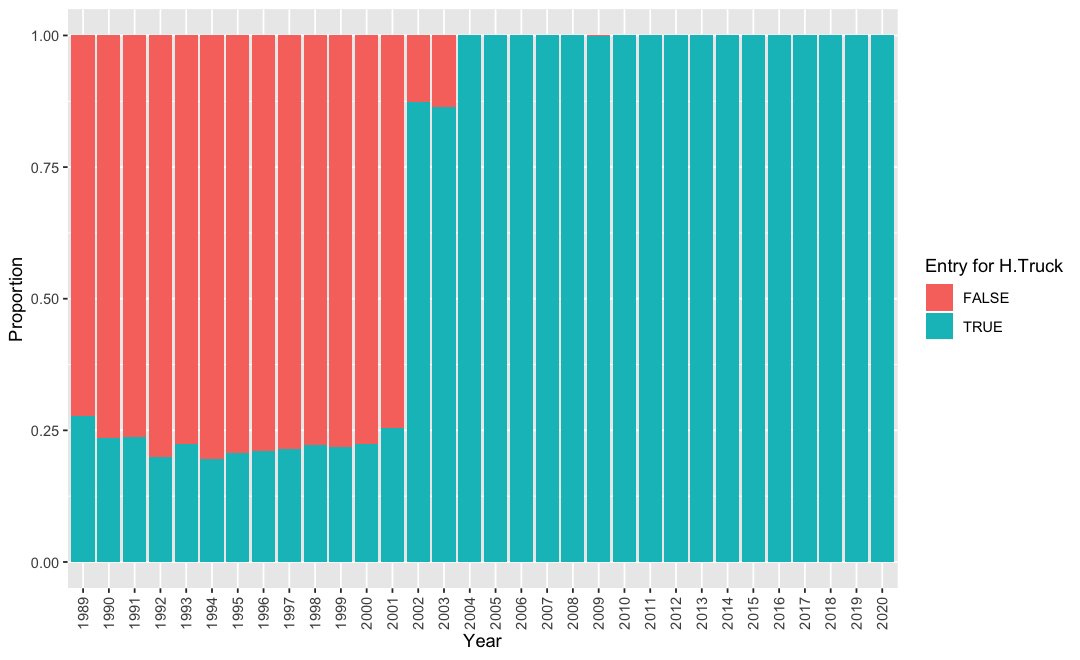

In [6]:
with(df, table(Year, H.Truck.Involvement != "Missing")) %>% 
    data.frame() %>% 
    ggplot(aes(x = Year, y = Freq, fill = Var2)) +
        geom_bar(stat="identity", position = "fill") +
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5)) +
        labs(fill = "Entry for H.Truck", y = "Proportion")

We see that records for `H.Truck.Involvement` were only taken consistently from 2002-2004 onwards. This strong relationship between `H.Truck.Involvement` and `Year` could introduce multicollinearity in our models moving forward, especially if the year of a crash ends up being a good predictor of `Gender`. One way to decide how to handle this variable, is to see if this variable individually has any relationship with the gender of a fatility, and if not, we will not include it in any of our modelling. To accomplish this we can perform a Chi-Squared test of homogeneity:

In [7]:
df %>%
  filter(H.Truck.Involvement != "Missing") %>% 
  droplevels() %>% 
  with(table(Gender, H.Truck.Involvement)) %>% 
  chisq.test()


	Pearson's Chi-squared test with Yates' continuity correction

data:  .
X-squared = 0.050477, df = 1, p-value = 0.8222


This high p-value of 0.8455 leads us to fail to reject the null hypothesis of homogeneity between the proportion of male/female fatalities and the proportion of fatalities involving a heavy rigid truck. We conclude that there is no evidence to suggest that the involvement of a heavy rigid truck has any relationship to the gender of a fatility, and as such, will not include this variable in any of our modelling.

In [8]:
df <- df %>% 
  select(-H.Truck.Involvement)

Given that the exact time of a crash may not be as of as much interest to us as the more general time period the crash took place in, we create a new categorical variable `Time.Period` for later use:

In [9]:
df <- within(df, {
  Time.Period <- NA
  Time.Period[Time >= hms(hours = 0) & Time <= hms(hours = 3, minutes = 59)] <- "Late Night"
  Time.Period[Time >= hms(hours = 4) & Time <= hms(hours = 7, minutes = 59)] <- "Early Morning"
  Time.Period[Time >= hms(hours = 8) & Time <= hms(hours = 11, minutes = 59)] <- "Mid Morning"
  Time.Period[Time >= hms(hours = 12) & Time <= hms(hours = 15, minutes = 59)] <- "Early Afternoon"
  Time.Period[Time >= hms(hours = 16) & Time <= hms(hours = 19, minutes = 59)] <- "Afternoon / Evening"
  Time.Period[Time >= hms(hours = 20) & Time <= hms(hours = 23, minutes = 59)] <- "Night"
})

df$Time.Period <- factor(df$Time.Period,
    levels = c("Early Morning", "Mid Morning", "Early Afternoon",
               "Afternoon / Evening", "Night", "Late Night"))

df$Time <- as.numeric(df$Time)

Lastly, we trim down some of the longer category names in our `Road.User` variable:

In [10]:
df <- df %>% 
    mutate(Road.User = factor(str_replace(Road.User, "Motorcycle pillion passenger", "MC. Pass.")),
           Road.User = factor(str_replace(Road.User, "Motorcycle rider", "MC. Rider")),
           Road.User = factor(str_replace(Road.User, "Pedal cyclist", "Cyclist")))

___
# 1. Classification
In this section we aim to create models that explain the gender of an Australian road fatality.

## 1.1 Classification Transformation
Our first step will be to split our data into Training, Calibration and Test data sets for our models. Our initial split will be:

* Train: 90%
* Test: 10%

In [11]:
df_ <- df %>% 
  select(-Crash.ID) # removing ID from any modelling data sets

set.seed(4009)
smpl_size <- floor(0.9 * nrow(df_))
train_idx <- sample(seq_len(nrow(df_)), size = smpl_size)

trainAll <- df_[train_idx, ]
test <- df_[-train_idx, ]

We then set our response variable as `Gender` and the positive outcome for it as "Female", then further split our training data into:

* Train: 90%
* Calibration: 10%  

This allows us to perform cross-validation during our single variable analaysis.

In [12]:
outcomes = c("Gender")
vars <- setdiff(colnames(trainAll), c(outcomes))

outcome <- "Gender"
pos <- "Female"

cal_idx <- rbinom(n = nrow(trainAll), size = 1, prob = 0.1) > 0
cal <- subset(trainAll, cal_idx)
train <- subset(trainAll, !cal_idx)

Before we begin any modelling tasks, it is valuable for us to discern what the majority class classifier (null model) is for our response variable in the data:

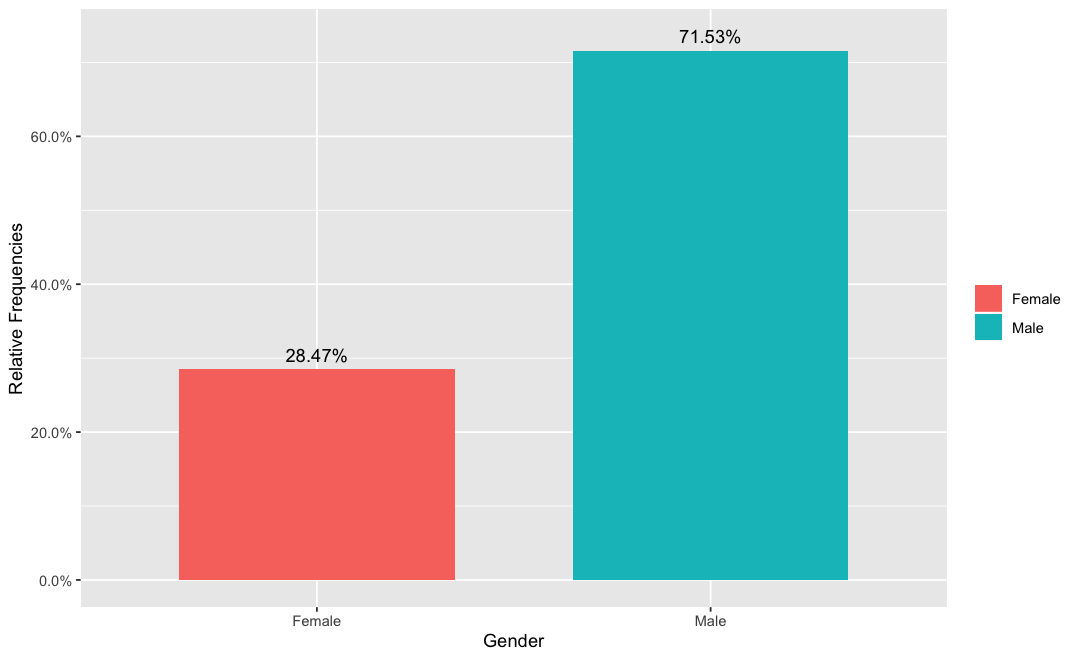

In [13]:
gndr.tab <- prop.table(table(df$Gender))
f <- round(gndr.tab[1], 4)
m <- round(gndr.tab[2], 4)

ggplot(df, aes(x = Gender, fill = Gender)) +
    geom_bar(aes(y = (..count..) / sum(..count..)), width = 0.7) + 
    scale_y_continuous(labels = percent_format()) +
    annotate("text", x = "Female", y = f + 0.02, label = paste0(f * 100, "%")) +
    annotate("text", x = "Male", y = m + 0.02, label = paste0(m * 100, "%")) +
    ylab("Relative Frequencies") +
    theme(legend.title = element_blank())

We see here that over 7/10 of the fatalities in our data are male, meaning our null model performs at a classification accuracy of 71.5%. This could cause some issues moving forward, as the models we train will have access to much more data for males than females, potentially leading to imbalanced predictions.  
A potential solution to this problem is a technique called Synthetic Oversampling, which generates a random set of minority class observations to shift the classifier learning bias towards minority class. In the article referenced below, this technique outperforms both simple undersampling and simple oversampling as ways to deal with inbalanced classifications.

https://www.analyticsvidhya.com/blog/2016/03/practical-guide-deal-imbalanced-classification-problems/

We will only use synthetic oversampling on the training data, as we want our test and calibration data to reflect real observations that our model accuracies will be measured on.

To perform this synthetic oversampling, we use the package `ROSE`, which stands for Random Over Sampling Examples. This package requires that all variables be transformed to a factor prior to synthetic sample generation:

In [14]:
rose.form <- Gender ~ State + Month + Year + Dayweek + Time + Crash.Type + 
    Bus.Involvement + A.Truck.Involvement + Speed.Limit + Road.User + Age + 
    Christmas.Period + Easter.Period + Day.of.week + Time.of.day + Time.Period + Age.Group

rose.train <- ROSE(rose.form, data = mutate_all(train, as.factor), seed = 4009)$data

To check if this synthetic sampling worked:

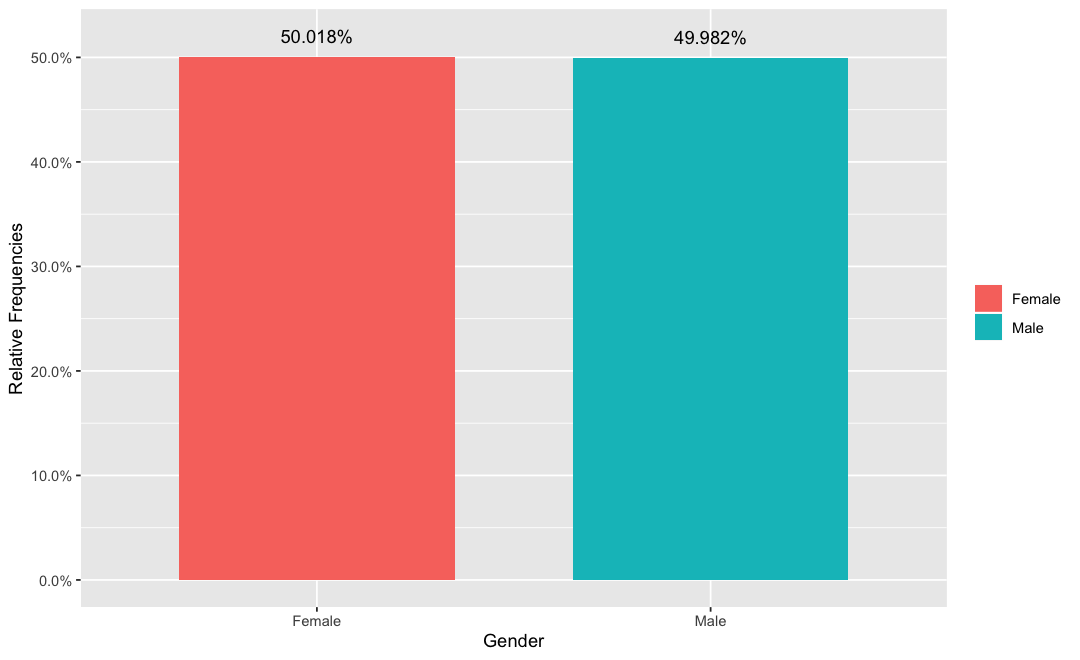

In [15]:
rose.train$Gender <- relevel(rose.train$Gender, ref = "Female")
rose.gndr.tab <- prop.table(table(rose.train$Gender))
f <- round(rose.gndr.tab[1], 5)
m <- round(rose.gndr.tab[2], 5)

ggplot(rose.train, aes(x = Gender, fill = Gender)) +
    geom_bar(aes(y = (..count..) / sum(..count..)), width=0.7) + 
    scale_y_continuous(labels = percent_format()) +
    annotate("text", x = "Female", y = f + 0.02, label = paste0(f * 100, "%")) +
    annotate("text", x = "Male", y = m + 0.02, label = paste0(m * 100, "%")) +
    ylab("Relative Frequencies") +
    theme(legend.title = element_blank())

rose.train$Gender <- relevel(rose.train$Gender, ref = "Male")

Now that we have a balanced data set for training, we'd like to convert all of our variables back to their correct class, which the following function achieves. We will also run our test and calibration data sets through this function to ensure the three datasets are in the exact same format.

In [16]:
numReverse <- function (df) {
    numV <- c("Month", "Year", "Time", "Speed.Limit", "Age")
    for (var in numV) {
        df[[var]] <- df[[var]] %>%
            as.character() %>%
            as.numeric
    }
    return(df)
}

rose.train <- numReverse(rose.train)
train <- numReverse(rose.train)
test <- numReverse(test)
cal <- numReverse(cal)

We can now create vectors of both categorical and numerical variables to be used in different single-variable modelling processes:

In [17]:
catVars <- vars[sapply(train[, vars], class) %in% c('factor', 'character')]
numVars <- vars[sapply(train[, vars], class) %in% c('numeric', 'integer')]

___
## 1.2 Single Variable Modelling
For our multi-variable modelling to be most effective, it can be valuable to begin with single-variable modelling to identify which variables on their own have a significant relationship with our response variable, `Gender`. We start with creating two functions, one for categorical variables and one for numeric variables. These functions take their respective variable, and create another column in our dataframe that is a numerical representation of the original variable, with a 'pred' prefix in the variable name.

In [18]:
mkPredC <- function(outCol, varCol, appCol) {
    pPos <- sum(outCol == pos) / length(outCol)
    naTab <- table(as.factor(outCol[is.na(varCol)]))
    pPosWna <- (naTab / sum(naTab))[pos]
    vTab <- table(as.factor(outCol), varCol)
    pPosWv <- (vTab[pos,] + 1.0e-3 * pPos) / (colSums(vTab) + 1.0e-3)
    pred <- pPosWv[appCol]
    pred[is.na(appCol)] <- pPosWna
    pred[is.na(pred)] <- pPos
    pred
}

mkPredN <- function(outCol, varCol, appCol) {
    cuts <- unique(as.numeric(quantile(varCol, probs = seq(0, 1, 0.1), na.rm = TRUE)))
    varC <- cut(varCol,cuts)
    appC <- cut(appCol,cuts)
    mkPredC(outCol,varC,appC)
}

We also create an AUC function that calculates the area under the ROC curve for a given variable so we are able to compare across variables:

In [19]:
calcAUC <- function(predcol, outcol) {
    perf <- performance(prediction(predcol, outcol == pos), 'auc')
    as.numeric(perf@y.values)
}

We now use our predictions functions and our AUC function to cycle through all of our categorical and numerical variables, to identify if any score greater than a given threshold. If the AUC is above the threshold, we print both the training data AUC and the calibration data AUC for comparison. If the training and calibration AUC's are close, it means that our training data is representative of our full data set and is appropriate to be run against the test data. These functions highlight overfitting, where models can potentially "remember" too much from the training data and then fail to generalise, underperforming against the test data set.

In [20]:
thresh = 0.5

for(var in catVars) {
    pred <- paste0("pred", var)
    
    rose.train[, pred] <- mkPredC(rose.train[, outcome], rose.train[, var], rose.train[, var])
    cal[, pred] <- mkPredC(rose.train[, outcome], rose.train[, var], cal[, var])
    test[, pred] <- mkPredC(rose.train[, outcome], rose.train[, var], test[, var])
    
    aucTrain <- calcAUC(rose.train[, pred], rose.train[, outcome])
    
    if(aucTrain >= thresh) {
        aucCal <- calcAUC(cal[, pred], cal[, outcome])
        print(sprintf("%s, trainAUC: %4.3f calibrationAUC: %4.3f", pred, aucTrain, aucCal))
}}

[1] "predState, trainAUC: 0.512 calibrationAUC: 0.507"
[1] "predDayweek, trainAUC: 0.532 calibrationAUC: 0.544"
[1] "predCrash.Type, trainAUC: 0.547 calibrationAUC: 0.554"
[1] "predBus.Involvement, trainAUC: 0.505 calibrationAUC: 0.507"
[1] "predA.Truck.Involvement, trainAUC: 0.507 calibrationAUC: 0.510"
[1] "predRoad.User, trainAUC: 0.673 calibrationAUC: 0.673"
[1] "predChristmas.Period, trainAUC: 0.502 calibrationAUC: 0.505"
[1] "predEaster.Period, trainAUC: 0.501 calibrationAUC: 0.499"
[1] "predAge.Group, trainAUC: 0.592 calibrationAUC: 0.598"
[1] "predDay.of.week, trainAUC: 0.532 calibrationAUC: 0.545"
[1] "predTime.of.day, trainAUC: 0.570 calibrationAUC: 0.573"
[1] "predTime.Period, trainAUC: 0.592 calibrationAUC: 0.583"


In [21]:
for(var in numVars) {
    pred <- paste0("pred", var)
    
    rose.train[, pred] <- mkPredN(rose.train[, outcome], rose.train[, var], rose.train[, var])
    test[, pred] <- mkPredN(rose.train[, outcome], rose.train[, var], test[, var])
    cal[, pred] <- mkPredN(rose.train[, outcome], rose.train[, var], cal[, var])
    
    aucTrain <- calcAUC(rose.train[, pred], rose.train[, outcome])
    
    if(aucTrain >= thresh) {
        aucCal <- calcAUC(cal[, pred], cal[, outcome])
        print(sprintf("%s, trainAUC: %4.3f calibrationAUC: %4.3f", pred, aucTrain, aucCal))
}}

[1] "predMonth, trainAUC: 0.514 calibrationAUC: 0.500"
[1] "predYear, trainAUC: 0.519 calibrationAUC: 0.528"
[1] "predTime, trainAUC: 0.595 calibrationAUC: 0.591"
[1] "predSpeed.Limit, trainAUC: 0.517 calibrationAUC: 0.517"
[1] "predAge, trainAUC: 0.598 calibrationAUC: 0.597"


For our variables that have an AUC above the threshold, we see that the training AUC and calibration AUC are very similar, indicating that the training data is representative of our full data set.

Our next step to confirm that our training data is appropriate, is cross validation. This function, which is replicated 100 times, recalculates the training/calibration data split and then runs the prediction function again on a specific variable. The average (mean) of these 100 repetitions should be comparable to the AUC calculated for that variable above, which is especially important as the above calculation uses ROSE data with synthetic samples, whilst the cross-validation does not. We will take the variable `Road.User` as an example:

In [22]:
fCross <- function(var) {
    useForCalRep <- rbinom(n = nrow(trainAll), size = 1, prob = 0.1 ) > 0 
    predRep <- mkPredC(trainAll[!useForCalRep, outcome],
                       trainAll[!useForCalRep, var],
                       trainAll[useForCalRep, var])
    calcAUC(predRep, trainAll[useForCalRep, outcome])
}

aucs <- replicate(100, fCross("Road.User"))

print(sprintf("cross-validation mean: %4.3f, cross-validation standard deviation: %4.3f", mean(aucs), sd(aucs)))

[1] "cross-validation mean: 0.676, cross-validation standard deviation: 0.007"


We see that for the `Road User` variable, the cross-validation mean is almost identical to the above AUC calculation (0.675 vs 0.674 respectively), with a small standard deviation. Running this function with the other variables that met our threshold gives similar results, confirming that our training data is ready to be used in further modelling.

___
## 1.3 Logistic Regression
Our response variable is binary (male / female), which suits a binary logistic regression model. But before fitting a regression model, we want to remove variables that are too highly correlated to each other, to avoid feeding the model duplicate information (causing multicollinearity). Examples of this duplicated information can be found in the variables:

- Dayweek / Day.of.week
- Time.of.day / Time.Period / Time
- Age / Age.Group

We will take the variable `Dayweek` over `Day.of.week`, `Age` over `Age_Group`, and the variable `Time` over its counterparts, as these variables provide more detailed infromation about the time of the observation.

In [23]:
cat.remove <- c("Day.of.week", "Time.of.day", "Time.Period", "Age.Group")
catVars.rm <- catVars[! catVars %in% cat.remove]

fV <- paste0(outcome," ~ ", paste(c(catVars.rm, numVars), collapse = " + "))

tVars <- paste0('pred', c(catVars.rm, numVars))
fV2 <- paste0(outcome," ~ ", paste(tVars, collapse = " + "))

We can now fit our logistic regression model and calculate the AUC values for the model against on our 

In [24]:
gender.log.regr <- glm(as.formula(fV2), data = rose.train, family = binomial(link = 'logit'))

log.pred <- c(
    calcAUC(predict(gender.log.regr, newdata = rose.train), rose.train[, outcome]),
    calcAUC(predict(gender.log.regr, newdata = cal), cal[, outcome]),
    calcAUC(predict(gender.log.regr, newdata = test), test[, outcome]))

log.pred

[1] 0.7237694 0.7237822 0.7156048

Thankfully, we can see that our model performs similarly on the three datasets. We will now take a look at the summary of the model:

In [25]:
summary(gender.log.regr)


Call:
glm(formula = as.formula(fV2), family = binomial(link = "logit"), 
    data = rose.train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0639  -1.0662   0.4977   1.0377   2.4554  

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -23.35965    1.86317 -12.538  < 2e-16 ***
predState                 1.62294    1.00382   1.617  0.10593    
predDayweek               2.93847    0.38029   7.727 1.10e-14 ***
predCrash.Type            3.59212    0.24069  14.924  < 2e-16 ***
predBus.Involvement       1.69147    0.56929   2.971  0.00297 ** 
predA.Truck.Involvement   9.46638    0.90645  10.443  < 2e-16 ***
predRoad.User             4.89681    0.07826  62.575  < 2e-16 ***
predChristmas.Period      2.38168    1.56999   1.517  0.12927    
predEaster.Period         6.06959    2.81367   2.157  0.03099 *  
predMonth                 4.88436    0.85049   5.743 9.30e-09 ***
predYear                  1.34625    0.62083   2

We notice here that we have a number of variables that fail the Wald's test, failing to reject the null hypothesis that the variable's coefficient is equal to zero. We will now perform backwards elimination on the model, until we are left only with variables that have a significant relationship with our response:

In [26]:
log.regr.be <- update(gender.log.regr, .~.-predEaster.Period)
summary(log.regr.be)


Call:
glm(formula = Gender ~ predState + predDayweek + predCrash.Type + 
    predBus.Involvement + predA.Truck.Involvement + predRoad.User + 
    predChristmas.Period + predMonth + predYear + predTime + 
    predSpeed.Limit + predAge, family = binomial(link = "logit"), 
    data = rose.train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0516  -1.0667   0.5184   1.0378   2.4539  

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -20.36191    1.24005 -16.420  < 2e-16 ***
predState                 1.62983    1.00384   1.624  0.10446    
predDayweek               2.92024    0.38020   7.681 1.58e-14 ***
predCrash.Type            3.58795    0.24067  14.908  < 2e-16 ***
predBus.Involvement       1.68440    0.56924   2.959  0.00309 ** 
predA.Truck.Involvement   9.48390    0.90641  10.463  < 2e-16 ***
predRoad.User             4.89631    0.07825  62.570  < 2e-16 ***
predChristmas.Period      2.34604    1.56983   1

In [27]:
log.regr.be <- update(log.regr.be, .~.-predBus.Involvement)
summary(log.regr.be)


Call:
glm(formula = Gender ~ predState + predDayweek + predCrash.Type + 
    predA.Truck.Involvement + predRoad.User + predChristmas.Period + 
    predMonth + predYear + predTime + predSpeed.Limit + predAge, 
    family = binomial(link = "logit"), data = rose.train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0009  -1.0677   0.5187   1.0393   2.4549  

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -19.60452    1.21323 -16.159  < 2e-16 ***
predState                 1.64651    1.00377   1.640   0.1009    
predDayweek               2.93503    0.38013   7.721 1.15e-14 ***
predCrash.Type            3.64458    0.23988  15.193  < 2e-16 ***
predA.Truck.Involvement   9.58515    0.90569  10.583  < 2e-16 ***
predRoad.User             4.90450    0.07824  62.689  < 2e-16 ***
predChristmas.Period      2.25975    1.56991   1.439   0.1500    
predMonth                 5.05694    0.84704   5.970 2.37e-09 ***
predYear 

In [28]:
log.regr.be <- update(log.regr.be, .~.-predYear)
summary(log.regr.be)


Call:
glm(formula = Gender ~ predState + predDayweek + predCrash.Type + 
    predA.Truck.Involvement + predRoad.User + predChristmas.Period + 
    predMonth + predTime + predSpeed.Limit + predAge, family = binomial(link = "logit"), 
    data = rose.train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9989  -1.0671   0.5164   1.0392   2.4533  

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -18.99212    1.17781 -16.125  < 2e-16 ***
predState                 1.64838    1.00370   1.642    0.101    
predDayweek               2.92279    0.38005   7.691 1.47e-14 ***
predCrash.Type            3.67367    0.23948  15.340  < 2e-16 ***
predA.Truck.Involvement   9.60182    0.90565  10.602  < 2e-16 ***
predRoad.User             4.91659    0.07805  62.997  < 2e-16 ***
predChristmas.Period      2.23403    1.56978   1.423    0.155    
predMonth                 5.05895    0.84702   5.973 2.33e-09 ***
predTime            

In [29]:
log.regr.be <- update(log.regr.be, .~.-predChristmas.Period)
summary(log.regr.be)


Call:
glm(formula = Gender ~ predState + predDayweek + predCrash.Type + 
    predA.Truck.Involvement + predRoad.User + predMonth + predTime + 
    predSpeed.Limit + predAge, family = binomial(link = "logit"), 
    data = rose.train)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-2.000  -1.067   0.526   1.040   2.453  

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -17.89374    0.88933 -20.120  < 2e-16 ***
predState                 1.65871    1.00361   1.653   0.0984 .  
predDayweek               2.94105    0.37982   7.743 9.69e-15 ***
predCrash.Type            3.66606    0.23941  15.313  < 2e-16 ***
predA.Truck.Involvement   9.62658    0.90545  10.632  < 2e-16 ***
predRoad.User             4.91852    0.07804  63.028  < 2e-16 ***
predMonth                 5.03627    0.84691   5.947 2.74e-09 ***
predTime                  4.00983    0.13641  29.396  < 2e-16 ***
predSpeed.Limit           2.77301    0.63452   4.370 

Before settling on this model, we will perform a Drop In Deviance test between it and our unconstrained model (before backwards elimination). The null hypothesis of this test is that the additional explanatory variables in the unconstrained model do not explain more of the change in our response variable than the contrained model, ie. that the constrained model is adequate:

In [30]:
anova(log.regr.be, gender.log.regr, test = "Chisq")

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,41179,49928.27,NA,NA,NA
2,41175,49908.18,4,20.08871,0.0004796589


The p-value of 0.4967 leads us to fail to reject the null hypothesis, and we can conclude that the constrained model, obtained from backwards selection, is preferable.

A valuable metric to calculate the quality of our model is the pseudo R-squared, which will help us measure how much deviance is explained by our explanatory variables:

In [31]:
ps.r.sq <- log.regr.be$deviance / log.regr.be$null.deviance
sprintf("Pseudo R-Squared: %.4f", ps.r.sq)

[1] "Pseudo R-Squared: 0.8744"

This figure tells us that our model explains 87.29% of the variation in Gender. 

___
## 1.4 Decision Trees
The second classification technique we will use decision trees. We will leverage the same formulas that were extablished in the logistic regression, with the first tree using the raw variables, the second tree using the 'pred' versions of these variables, the the third tree use the raw variables again but controlling for aspects of the tree such as depth and splits.

In [32]:
fV <- paste0(outcome," == 'Female' ~ ", paste(c(catVars.rm, numVars), collapse = " + "))
rose.tmodel1 <- rpart(fV, data = rose.train)

Rose.Tree.1 <- c(
    calcAUC(predict(rose.tmodel1, newdata = rose.train), rose.train[, outcome]),
    calcAUC(predict(rose.tmodel1, newdata = cal), cal[, outcome]),
    calcAUC(predict(rose.tmodel1, newdata = test), test[, outcome]))
Rose.Tree.1

[1] 0.6884391 0.6925280 0.6793860

In [33]:
tVars <- paste0('pred', c(catVars.rm, numVars))
fV2 <- paste0(outcome," == 'Female' ~ ", paste(tVars, collapse = " + "))
rose.tmodel2 <- rpart(fV2, data = rose.train)

Rose.Tree.2 <- c(
    calcAUC(predict(rose.tmodel2, newdata = rose.train), rose.train[, outcome]),
    calcAUC(predict(rose.tmodel2, newdata = cal), cal[, outcome]),
    calcAUC(predict(rose.tmodel2, newdata = test), test[, outcome]))
Rose.Tree.2

[1] 0.6986392 0.6995835 0.6928944

In [34]:
rose.tmodel3 <- rpart(fV, data = rose.train,
                control = rpart.control(cp = 0.001, minsplit = 1000,
                                      minbucket = 1000, maxdepth = 5))

Rose.Tree.3 <- c(
    calcAUC(predict(rose.tmodel3, newdata = rose.train), rose.train[, outcome]),
    calcAUC(predict(rose.tmodel3, newdata = cal), cal[, outcome]),
    calcAUC(predict(rose.tmodel3, newdata = test), test[, outcome]))
Rose.Tree.3

[1] 0.7153071 0.7159041 0.7042395

In [35]:
dt.matrix <- matrix(c(Rose.Tree.1, Rose.Tree.2, Rose.Tree.3), 
                    nrow = 3, ncol = 3, byrow = FALSE, 
                    dimnames = list(c("Train", "Cal", "Test"),
                                    c("Tree.1", "Tree.2", "Tree.3")))
dt.matrix

,Tree.1,Tree.2,Tree.3
Train,0.6884391,0.6986392,0.7153071
Cal,0.6925280,0.6995835,0.7159041
Test,0.6793860,0.6928944,0.7042395


Looking at our three decision tree results, we see very comprable numbers within each tree for training, calibration and testing. This is likely due to our dilligence in the single-variable stage, as we ensured that the training data was fit for modelling. For the in depth analysis of the decision tree and the associated visual representation, we will use the third tree where we controlled for aspects as it gives us the best test results:

In [36]:
print(rose.tmodel3)

n= 41189 

node), split, n, deviance, yval
      * denotes terminal node

 1) root 41189 10297.2500 0.5001821  
   2) Road.User=Cyclist,MC. Rider 4583   495.3458 0.1232817 *
   3) Road.User=Driver,MC. Pass.,Other,Passenger,Pedestrian 36606  9069.3620 0.5473693  
     6) Road.User=Driver,Pedestrian 24529  6117.6470 0.4756003  
      12) Time< 23220 4248   912.0932 0.3121469 *
      13) Time>=23220 20281  5068.2880 0.5098368  
        26) Time>=71190 3880   911.1124 0.3768041  
          52) Crash.Type=Single 1620   347.2000 0.3111111 *
          53) Crash.Type=Multiple,Pedestrian 2260   551.9097 0.4238938 *
        27) Time< 71190 16401  4072.2640 0.5413085  
          54) Speed.Limit>=65 10536  2633.3140 0.5080676 *
          55) Speed.Limit< 65 5865  1406.3940 0.6010230 *
     7) Road.User=MC. Pass.,Other,Passenger 12077  2568.7610 0.6931357  
      14) Age< 47.5 8172  1925.4770 0.6199217  
        28) Time< 26550 2116   528.9428 0.5051985 *
        29) Time>=26550 6056  1358.9540 0.6

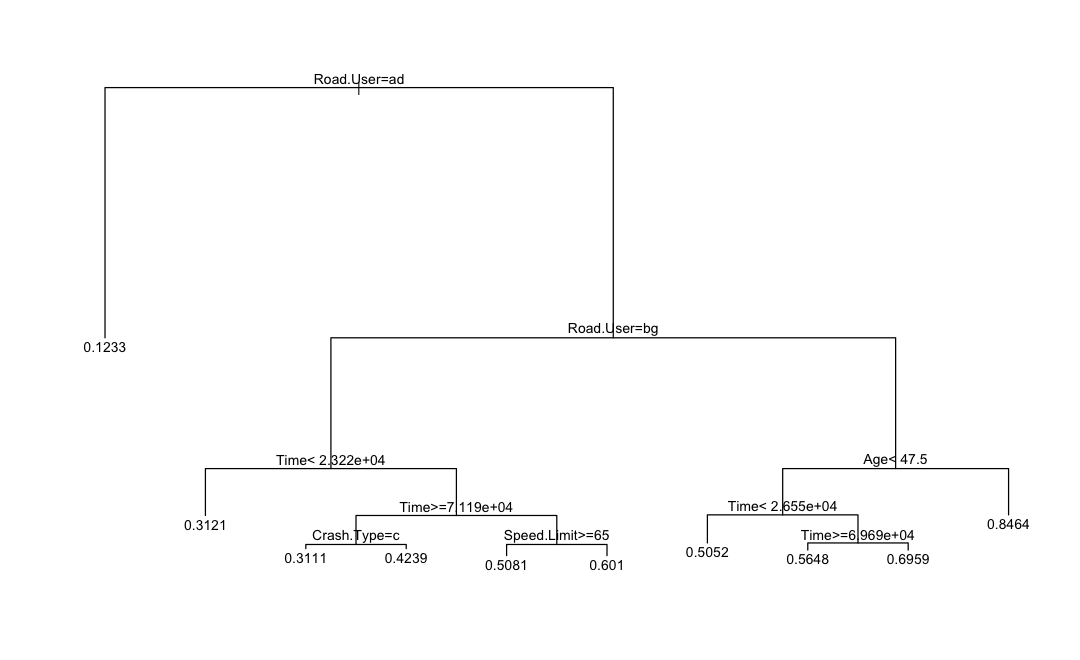

In [37]:
par(cex = 0.7)
plot(rose.tmodel3)
text(rose.tmodel3)

Looking at both the textual and visual display of our decision tree, we look to see where our 'yval' is substanitally above or below 0.5 as that is where the odds of being male are equivalent to being female for the respective node. Two points really stand out in this regard:

* The first is 0.135 - This node has a very low probability of the fatality being female where the 'Road User' is equal to Cyclist or Motorcycle Rider. Going back to the original data, we see that the number of Female & Cyclist is around 14% so that is in line, but the number of Female and Motocycle Rise is only 4%. This discrepancy shows that even though there are substantially more male motorcycle riders, our decision tree is predicting almost triple the number of female fatalities that we would expect.

* The second is 0.845 - This node on the far right has a very high probability of the fatality being female, where 'Road User' is equal to Motorcycle Passenger, Passenger or Other and the Age is greater or equal to 47.5. Again, going back to the original data, we see that only 68% of fatalities in the category are female. This reveals that at that node, the model is prediciting a much higher probability of being Female than our data would suggest.  

Running a different decision tree package but with the same inputs as the third decision tree from above, we see similar variables playing a part in the model. Road User, Time Period and Age Group are all part of branches in our above tree visual. To note for the tree below though, it is resticted to only 3 levels deep due to the ability to read and interpret the visual semi-easily.

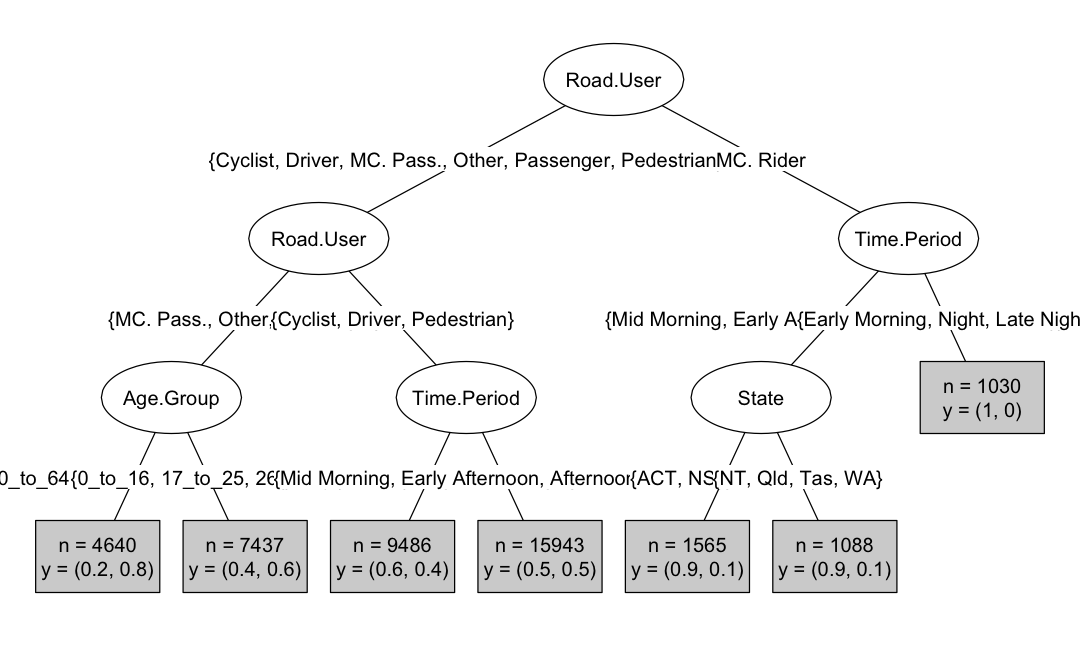

In [38]:
r.dt<- ctree(formula = rose.form, data = rose.train, 
           controls = ctree_control(minsplit = 1000, minbucket = 1000, maxdepth = 3))

plot(r.dt, type = "simple",
     inner_panel = node_inner(r.dt, pval = FALSE, id = FALSE),
     terminal_panel = node_terminal(r.dt, digits = 1, id = FALSE))

At each leaf of the tree, we see the total number of fatalities and the Male / Female split between them. What stands out here is that on the left of the tree the leaves are fairly gender balanced, but on the right, where Road.User = Motorcycle Rider, we see a significant skew towards the fatalities being male. We also see the inverse of this in the branch for Motorcycle Passenger, Passenger and Other, with the majority of the fatalities here being female. This modelling would infer that fatalities of riders of motorcycles are predominantly male, whilst passenger fatalities are more often female.

___
## 1.5 Classification Model Comparisons / Evaluation
Having modelled our logistic regression and our three decision trees, we create the visual to compare them against each other and the null model:

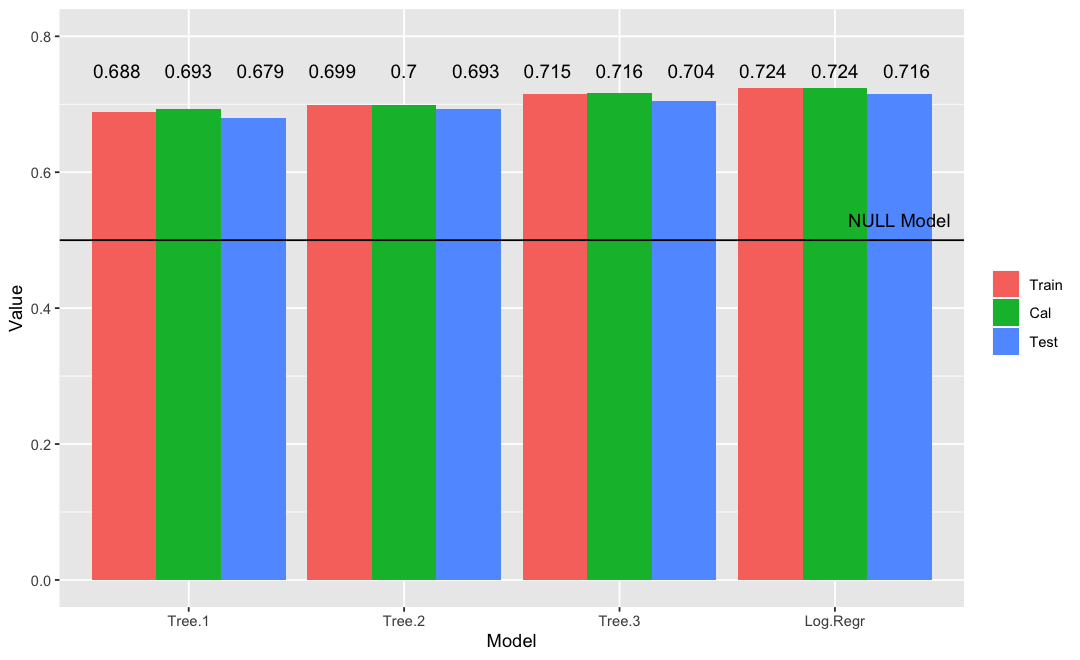

In [39]:
dtl.df <- data.frame(Model = rep(c("Tree.1", "Tree.2", "Tree.3", "Log.Regr"), each = 3),
                    Data = rep(c("Train", "Cal", "Test"), times = 4),
                    Value = c(Rose.Tree.1, Rose.Tree.2, Rose.Tree.3, log.pred))

ggplot(dtl.df, aes(x = factor(Model, levels = unique(Model)), y = Value,
                  fill = factor(Data, levels = unique(Data)))) +
    geom_bar(stat = "identity", position = "dodge") +
    geom_text(aes(y = 0.75, label = round(Value, digits = 3)), position = position_dodge(width = 1), size = 4) +
    geom_hline(yintercept = 0.5, color = "black") +
    annotate(geom = "text", x = 4.3, y = 0.53, label = "NULL Model", colour = "black") +
    ylim(0, 0.8) +
    ylab("Value") +
    xlab("Model") +
    theme(legend.title = element_blank())

This plot shows that all of our models outperformed the null model, and that our logistic regression narrowly outperformed the decision tree models. Selecting the logistic regression as our preferred model, we will perform some additional analysis into it's prediction quality. Firstly, we can use the model to predict the gender (a value between 0 and 1) of fatalities in our dataset: 

In [40]:
rose.train$pred <- predict(log.regr.be, newdata = rose.train, type = "response")
test$pred <- predict(log.regr.be, newdata = test, type = "response")

rose.train <- rose.train %>% mutate(Female = ifelse(Gender == "Female", TRUE, FALSE))
test <- test %>% mutate(Female = ifelse(Gender == "Female", TRUE, FALSE))

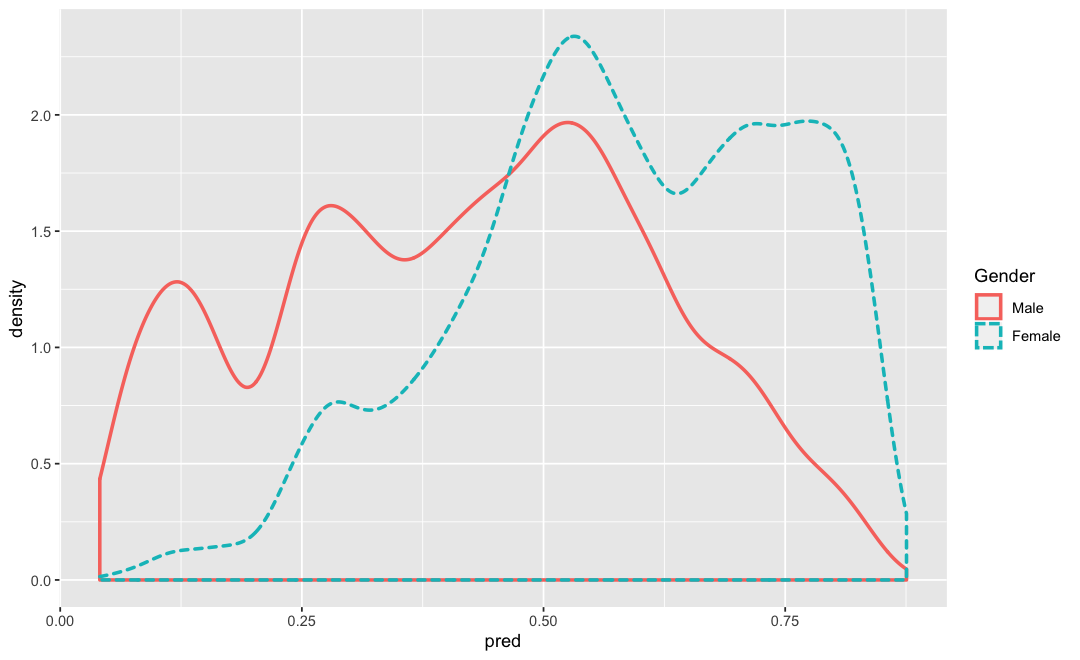

In [41]:
ggplot(rose.train, aes(x = pred, colour = Gender, linetype = Gender)) +
  geom_density(size = 1)

This plot shows the distribution of predictions when the true label is either Male or Female. Ideally, we'd like to see the two distributions completely separated, which isn't the case here, suggesting that our we cannot build a classifier from our model that simultaneously achieves good recall and good precision.

From a plot of our model's recall, F1 score and (precision / null model precision) over a range of thresholds, we aim to identify a comprimising classification threshold:

In [42]:
predObj <- prediction(rose.train$pred, rose.train$Female)
precObj <- performance(predObj, measure = "prec")
recObj <- performance(predObj, measure = "rec")
precision <- (precObj@y.values)[[1]]
prec.x <- (precObj@x.values)[[1]]
recall <- (recObj@y.values)[[1]]
rocFrame <- data.frame(threshold = prec.x,
                       precision = precision,
                       recall = recall)

pnull <- mean(as.numeric(rose.train$Female))

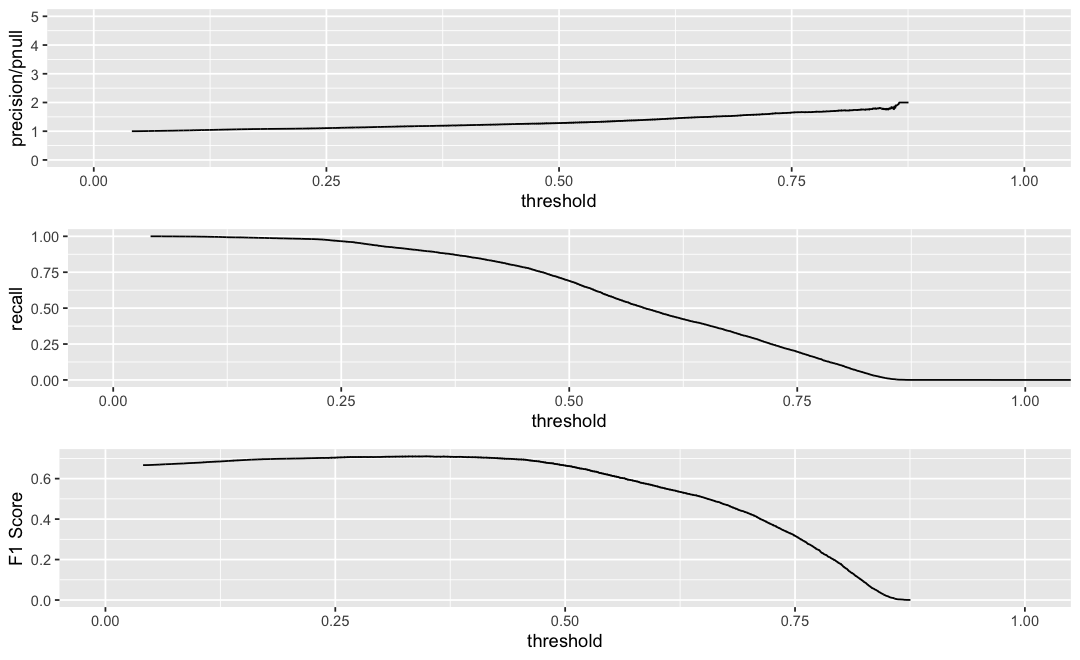

In [43]:
p <- ggplot(rocFrame, aes(x = threshold))
p1 <- p +
    geom_line(aes(y = precision / pnull)) +
    coord_cartesian(xlim = c(0, 1), ylim = c(0, 5))

p2 <- p +
    geom_line(aes(y = recall)) +
    coord_cartesian(xlim = c(0, 1))

p3 <- p + geom_line(aes(y = 2 * ((precision * recall) / (precision + recall)))) +
    ylab("F1 Score") +
    coord_cartesian(xlim = c(0, 1))

grid.arrange(p1, p2, p3, nrow = 3)

We can also calculate our precision, recall, enrichment rate and F1 score for our logistic regression model applied to our test data. We will look at these over a range of classification thresholds to help us select one for use:

In [44]:
thresh.eval <- function(df, thresh) {
    ctab <- table(pred = df$pred > thresh, Female = df$Female)
    
    precision <- ctab[2, 2] / sum(ctab[2, ])
    recall <- ctab[2, 2] / sum(ctab[, 2])
    enrich <- precision / mean(as.numeric(df$Female))
    
    F1 <- 2 * ((precision * recall) / (precision + recall))
    
    sprintf("Thresh: %4.2f, F1: %4.4f, Precision: %4.4f, Recall: %4.4f, Enrich: %4.4f", 
            thresh, F1, precision, recall, enrich)
}

In [45]:
for (i in seq(0.05, 0.85, by = 0.05)) {
  print(thresh.eval(test, i))
}

[1] "Thresh: 0.05, F1: 0.4459, Precision: 0.2870, Recall: 1.0000, Enrich: 1.0047"
[1] "Thresh: 0.10, F1: 0.4586, Precision: 0.2979, Recall: 0.9959, Enrich: 1.0431"
[1] "Thresh: 0.15, F1: 0.4759, Precision: 0.3134, Recall: 0.9883, Enrich: 1.0973"
[1] "Thresh: 0.20, F1: 0.4869, Precision: 0.3239, Recall: 0.9800, Enrich: 1.1342"
[1] "Thresh: 0.25, F1: 0.4976, Precision: 0.3353, Recall: 0.9642, Enrich: 1.1741"
[1] "Thresh: 0.30, F1: 0.5165, Precision: 0.3572, Recall: 0.9325, Enrich: 1.2506"
[1] "Thresh: 0.35, F1: 0.5232, Precision: 0.3707, Recall: 0.8891, Enrich: 1.2978"
[1] "Thresh: 0.40, F1: 0.5306, Precision: 0.3870, Recall: 0.8437, Enrich: 1.3552"
[1] "Thresh: 0.45, F1: 0.5279, Precision: 0.4013, Recall: 0.7713, Enrich: 1.4051"
[1] "Thresh: 0.50, F1: 0.5119, Precision: 0.4160, Recall: 0.6653, Enrich: 1.4566"
[1] "Thresh: 0.55, F1: 0.4976, Precision: 0.4460, Recall: 0.5627, Enrich: 1.5615"
[1] "Thresh: 0.60, F1: 0.4632, Precision: 0.4767, Recall: 0.4504, Enrich: 1.6690"
[1] "Thresh: 0.6

Here, we might select 0.45 as the threshold, as it has the maximum F1 score on our test data. The F1 score is a measure of our model's accuracy that takes into account both precision and recall.

___
# 2. Clustering
For our clustering analysis, we have a new task: we want to explore relationships between differently aged road users of differing types, according to the speed and time of the accident. To accomplish this, and considering our data is primarily categorical, we need to create a new dataset from our original data, with numerical representations of the variables of interest. We will create a new dataframe, with each observation being a different age group and road user type (for example: "Middle Aged Motorcycle Rider"), and variables decribing the speed limit and time of the crash.

## 2.1 Clustering Transformations
The clustering transformations begin with the same dataframe that was used for classification, without synthetic oversampling. We then join with the crashes data set to get the number of fatalities that were involved in the crash to be associated with each of our individual fatality oberservations.

In [46]:
crashes.join <- crashes %>% 
  select(c("Crash ID", "Number Fatalities"))

colnames(crashes.join) <- str_replace_all(colnames(crashes.join), c(" " = "."))
crashes.join$Crash.ID <- as.factor(crashes.join$Crash.ID)

c.df <- df %>%
    left_join(crashes.join, by = "Crash.ID") %>%
    as.data.frame() %>% 
    mutate(Month = as.numeric(Month), Year = as.numeric(Year),
           Age = as.numeric(Age), Speed.Limit = as.numeric(Speed.Limit)) %>%
    mutate_if(is.character, as.factor)

c.df$Road.User <- revalue(c.df$Road.User, c("Other/-9" = "Other"))

The following `from` values were not present in `x`: Other/-9



We then provide more meaningful names to our Age.Group variable:

In [47]:
c.df <- within(c.df, {
  Age.Grp.Name <- NA
  Age.Grp.Name[Age.Group == "0_to_16"] <- "Child"
  Age.Grp.Name[Age.Group == "17_to_25"] <- "Young adult"
  Age.Grp.Name[Age.Group == "26_to_39"] <- "Adult"
  Age.Grp.Name[Age.Group == "40_to_64"] <- "Middle aged"
  Age.Grp.Name[Age.Group == "65_to_74"] <- "Older"
  Age.Grp.Name[Age.Group == "75_or_older"] <- "Elderly"
})

c.df$Age.Grp.Name <- factor(c.df$Age.Grp.Name,
                            levels = c("Child", "Young adult",
                                       "Adult", "Middle aged",
                                       "Older", "Elderly"))

and look at the distribution of fatal crashes between these age groups:

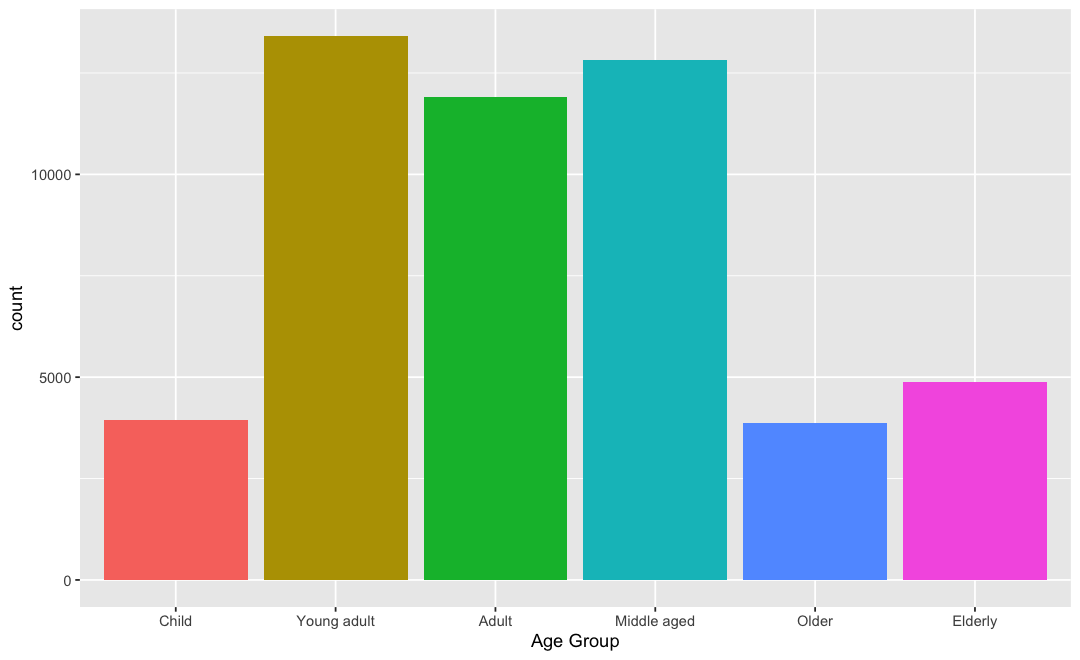

In [48]:
c.df %>% 
    ggplot(aes(x = Age.Grp.Name, fill = Age.Grp.Name)) +
        geom_bar() +
        xlab("Age Group") +
        theme(legend.position = "")

Now we will create our new dataframe, where each observation is a different age group and road user. We also add a summary column containing the average `Speed.Limit` a fatal crash occurs in in each group, and a column for each `Time.Period` during the day, with each value being the percentage of crashes in that group occurring in that time period:

In [49]:
c.df <- c.df %>%
    mutate(Road.User.Age = factor(paste0(Age.Grp.Name, ".", Road.User)))

clust.df <- c.df %>% 
    group_by(Road.User.Age) %>% 
    filter(Speed.Limit != "Missing") %>% 
    dplyr::summarise(avgSpeed = round(mean(as.numeric(Speed.Limit))))

In [50]:
n <- length(levels(c.df$Road.User.Age))
t <- round(prop.table(with(c.df, table(Road.User.Age, Time.Period)), 1), 4) * 100
split.tab <- split(t, ceiling(seq_along(t)/n))

clust.df$percEarlyMorn <- split.tab$`1`
clust.df$percMidMorn <- split.tab$`2`
clust.df$percEarlyAft <- split.tab$`3`
clust.df$percAftEve <- split.tab$`4`
clust.df$percNight <- split.tab$`5`
clust.df$percLateNight <- split.tab$`6`

head(clust.df, 10)

Road.User.Age,avgSpeed,percEarlyMorn,percMidMorn,percEarlyAft,percAftEve,percNight,percLateNight
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Adult.Cyclist,74,26.18,13.73,19.31,22.75,13.30,4.72
Adult.Driver,90,14.42,12.17,16.10,20.78,20.35,16.18
Adult.MC. Pass.,81,4.65,11.63,24.42,29.07,17.44,12.79
Adult.MC. Rider,76,10.53,13.85,23.76,28.42,15.15,8.29
Adult.Other,93,12.50,6.25,31.25,25.00,12.50,12.50
Adult.Passenger,90,10.82,11.55,18.25,22.58,20.52,16.29
Adult.Pedestrian,74,11.62,5.88,6.17,20.99,31.95,23.38
Child.Cyclist,71,6.10,16.77,25.00,46.65,5.18,0.30
Child.Driver,86,12.90,10.60,19.35,15.67,17.05,24.42


___
## 2.2 Finding k
We are using the euclidean distance for our clustering as it is the straight line distance between our points that we are interested in:

In [51]:
vars.to.use <- colnames(clust.df)[-1]
pmatrix <- scale(clust.df[, vars.to.use])

pcenter <- attr(pmatrix, "scaled:center")
pscale <- attr(pmatrix, "scaled:scale")

d <- dist(pmatrix, method = "euclidean")

Before performing our clustering, we need to find the optimal value for `k` to use. `k` will be the number of clusters that we model against, and it can be derived through the within sum of squares (the average distance from each point to the centre of its cluster) and the between sum of squares (the average distance between clusters):

In [52]:
sqr_edist <- function(x, y) {
  sum((x - y) ^ 2)
}

wss.cluster <- function(clustermat) {
  c0 <- apply(clustermat, 2, FUN = mean)
  sum(apply(clustermat, 1, 
            FUN = function(row) {sqr_edist(row, c0)}))
}

wss.total <- function(dmatrix, labels) {
  wsstot <- 0
  k <- length(unique(labels))
  for(i in 1:k){
    wsstot <- wsstot + 
      wss.cluster(subset(dmatrix, labels == i))
  }
  wsstot
}

totss <- function(dmatrix) {
  grandmean <- apply(dmatrix, 2, FUN = mean)
  sum(apply(dmatrix, 1, 
            FUN=function(row) {
              sqr_edist(row, grandmean)
              }
            )
      )
}

The Calinski-Harabasz (CH) index is a popular metric for selecting the optimum value for `k`. The CH index is defined as the ratio of the between-cluster variance to the total within-cluster variance. The following function computes this CH index:

In [53]:
rm(var)
ch_criterion <- function(dmatrix, kmax, method = "kmeans") {
  if(!(method %in% c("kmeans", "hclust"))){ 
    stop("method must be one of c('kmeans', 'hclust')")
  }
  npts <- nrow(dmatrix)
  totss <- totss(dmatrix)
  wss <- numeric(kmax)
  crit <- numeric(kmax)
  wss[1] <- (npts - 1) * sum(apply(dmatrix, 2, FUN = var))
  
  for(k in 2:kmax) {
    if(method == "kmeans") {
      clustering <- kmeans(dmatrix, k, nstart = 10, iter.max = 100)
      wss[k] <- clustering$tot.withinss
    }else {
      d <- dist(dmatrix, method = "euclidean")
      pfit <- hclust(d, method = "ward")
      labels <- cutree(pfit, k = k)
      wss[k] <- wss.total(dmatrix, labels)
    }
  }
  bss <- totss - wss
  crit.num <- bss / (0:(kmax - 1))
  crit.denom <- wss/(npts - 1:kmax)
  list(crit = crit.num / crit.denom, wss = wss, bss = bss, totss = totss)
}

Typically, the CH index is then plotted over a range of different values for `k`, and if a clear "elbow" is present (where the benefit of an increased number of clusters slows down), that value is selected as `k`.

In [ ]:
clustcrit <- ch_criterion(pmatrix, 20, method = "hclust")
critframe <- data.frame(k = 1:20, ch = scale(clustcrit$crit), wss = scale(clustcrit$wss), bss = scale(clustcrit$bss))
critframe <- melt(critframe, id.vars = c("k"), variable.name = "measure", value.name = "score")

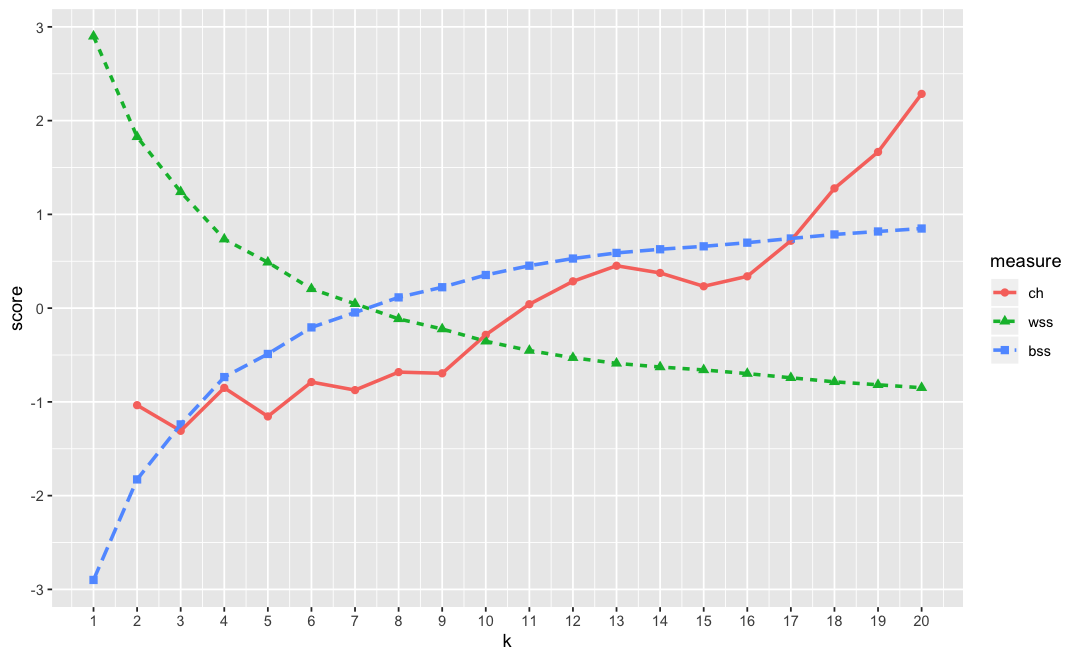

In [55]:
ggplot(critframe, aes(x = k, y = score, color = measure)) +
    geom_point(aes(shape = measure), size = 2) + 
    geom_line(aes(linetype = measure), size = 1) +
    scale_x_continuous(breaks = 1:20, labels = 1:20)

As our CH index simply increases, it is difficult to interpret from it a good value for `k`. We will instead make use of an `R` function named `NbClust`, which finds the optimum value for `k` as reported from over 30 different clustering indexes, then tallies these results:

*** : The Hubert index is a graphical method of determining the number of clusters.
                In the plot of Hubert index, we seek a significant knee that corresponds to a 
                significant increase of the value of the measure i.e the significant peak in Hubert
                index second differences plot. 
 


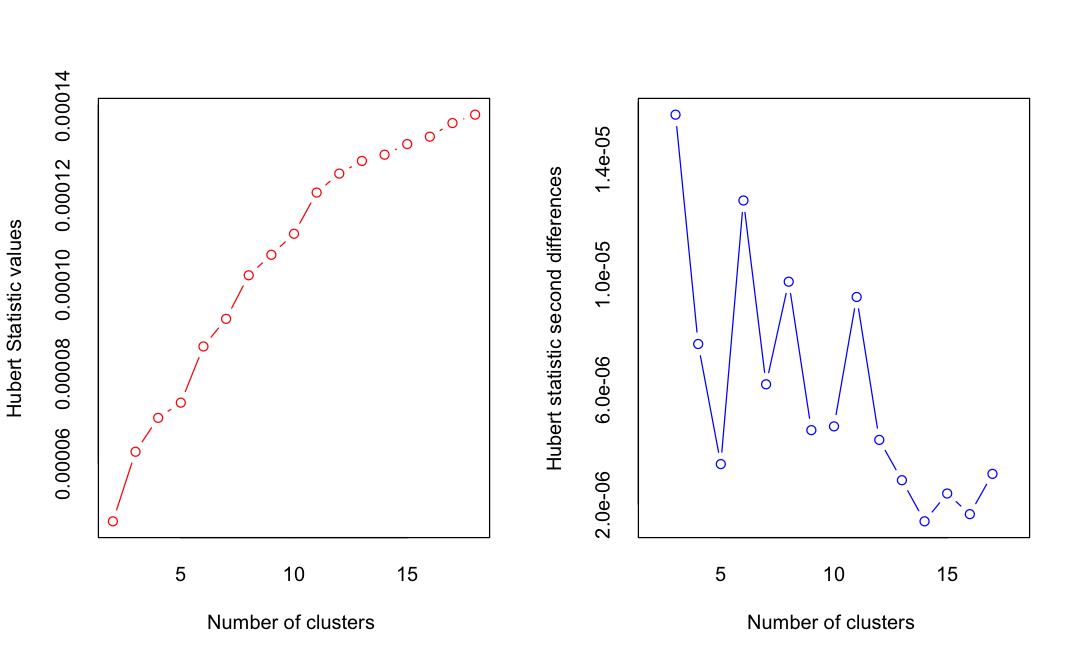

*** : The D index is a graphical method of determining the number of clusters. 
                In the plot of D index, we seek a significant knee (the significant peak in Dindex
                second differences plot) that corresponds to a significant increase of the value of
                the measure. 
 
******************************************************************* 
* Among all indices:                                                
* 4 proposed 2 as the best number of clusters 
* 2 proposed 3 as the best number of clusters 
* 6 proposed 4 as the best number of clusters 
* 1 proposed 5 as the best number of clusters 
* 2 proposed 6 as the best number of clusters 
* 1 proposed 9 as the best number of clusters 
* 1 proposed 15 as the best number of clusters 
* 2 proposed 17 as the best number of clusters 
* 4 proposed 18 as the best number of clusters 

                   ***** Conclusion *****                            
 
* According to the majority rule, the best number of

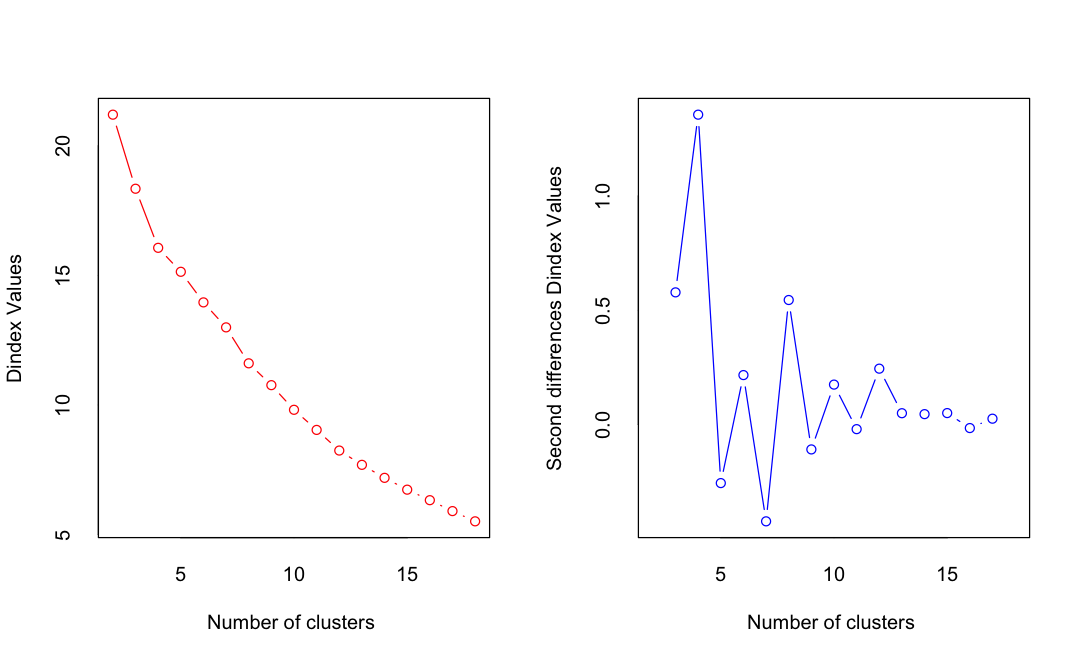

In [56]:
library(NbClust)
library(factoextra)
k.select <- clust.df %>% 
    select(-Road.User.Age) %>% 
    NbClust(method = "ward.D2", index = "all", min.nc = 2, max.nc = 18)

Among all indices: 
* 2 proposed  0 as the best number of clusters
* 1 proposed  1 as the best number of clusters
* 4 proposed  2 as the best number of clusters
* 2 proposed  3 as the best number of clusters
* 6 proposed  4 as the best number of clusters
* 1 proposed  5 as the best number of clusters
* 2 proposed  6 as the best number of clusters
* 1 proposed  9 as the best number of clusters
* 1 proposed  15 as the best number of clusters
* 2 proposed  17 as the best number of clusters
* 4 proposed  18 as the best number of clusters

Conclusion
* According to the majority rule, the best number of clusters is  4 .



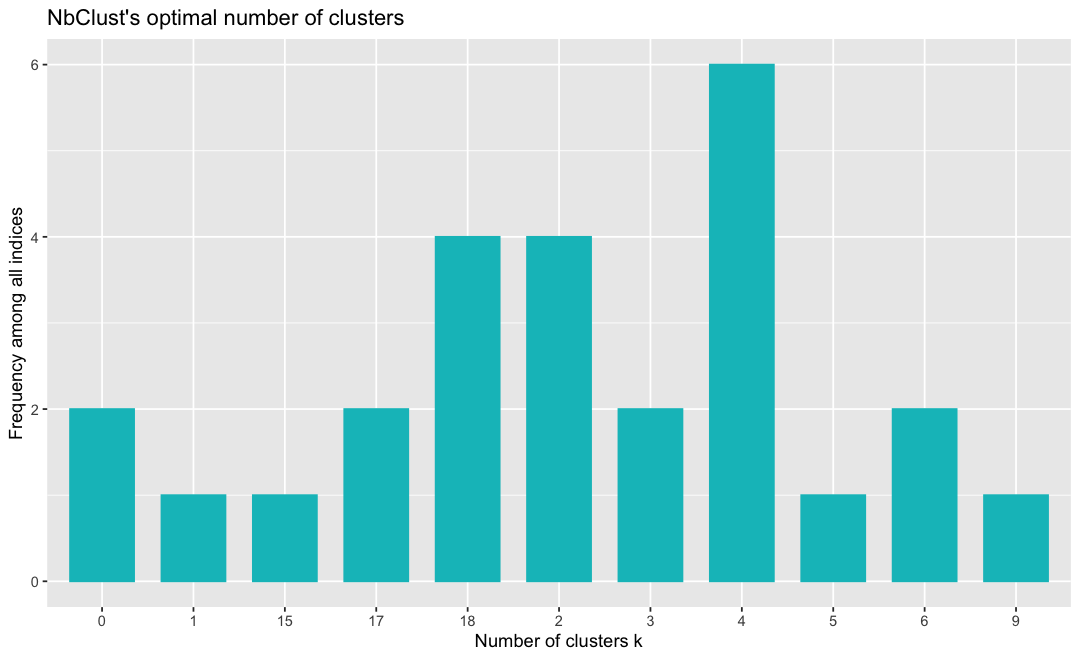

In [57]:
fviz_nbclust(k.select, barfill = "#00BFC4", barcolor = "#00BFC4") + 
    theme_gray() +
    ggtitle("NbClust's optimal number of clusters")

From this, we can see that the majority of clustering indexes selected 4 as the optimum value for `k`. Using this value, we use the clusterboot function to see the stability of these clusters:

In [58]:
kbest.p <- 4
cboot.hclust <- clusterboot(pmatrix,
                            clustermethod = hclustCBI,
                            method = "ward.D",
                            k = kbest.p,
                            count=FALSE)

groups <- cboot.hclust$result$partition

1 - cboot.hclust$bootbrd / 100

[1] 0.67 0.89 0.72 0.90

Using a value of roughly 0.70 to represent stability, we see that each cluster is roughly stable. This confirms 4 as our value for `k`.

___
## 2.3 Hierarchical Clustering
The clustering methodology we will use is hierarchical clustering. The below dendrogram displays each of our 42 'Road User Age' groups in their respective cluster:

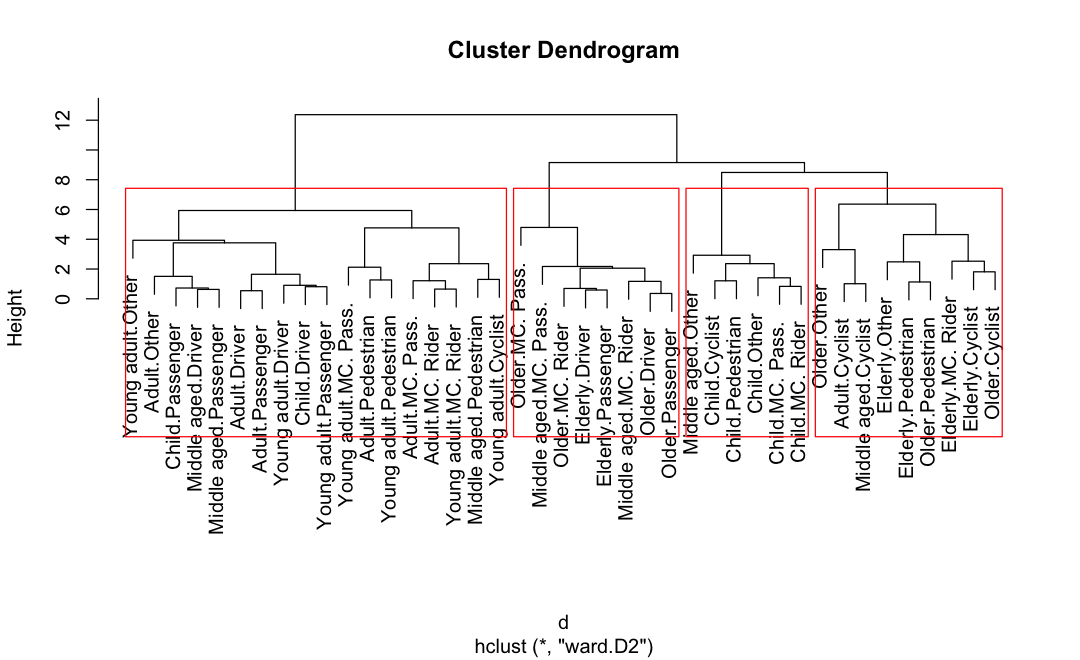

In [59]:
pfit <- hclust(d, method="ward.D2")
plot(pfit, labels = clust.df$Road.User.Age)
rect.hclust(pfit, k = kbest.p)

Using principal component transformation, we will plot the clusters for a clear visual respresentation:

In [60]:
groups <- cutree(pfit, k = kbest.p)
princ <- prcomp(pmatrix)
nComp <- 2
project <- as.data.frame(predict(princ, newdata=pmatrix)[,1:nComp])
project.plus <- cbind(project, cluster=as.factor(groups), Group=clust.df$Road.User.Age)

h <- do.call(
    rbind, 
    lapply(
        unique(groups),
        function(c) { 
            f <- subset(project.plus, cluster == c); 
            f[chull(f), ]
        }
    )
)

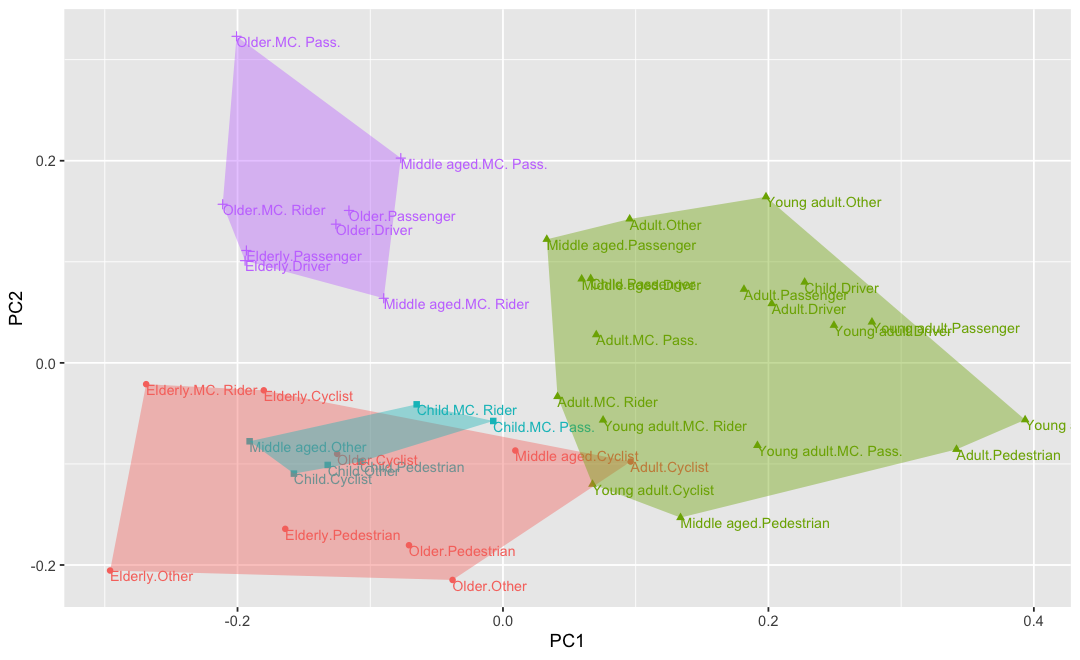

In [61]:
ggplot(project.plus, aes(x = PC1, y = PC2)) +
    geom_point(aes(shape = cluster, color = cluster)) +
    geom_text(aes(label = Group, color = cluster),
              hjust = 0, vjust = 1, size = 3) +
    geom_polygon(data = h, aes(group = cluster, fill = as.factor(cluster)),
                 alpha = 0.4, linetype = 0) +
    theme(legend.position = "")

We see distinction between our clusters in the plot with minor overlap towards the edges. Perhaps the most interesting observation from this visualisation is that the various age groups have to some degree clustered together, with the red and purple clusters consisting of almost entirely "Older" and "Elderly" groups, the green containing mostly "Adult" and "Young Adult", and the blue being almost entirely comprised of "Child" observations. This suggests that a relationship does exist between these groups and the speed and time of the crash.

___
## Conclusion
In this exploration and analysis of Australian road fatalities, we faced a number of challenges:

* Many variables with missing data
* Imbalanced data for classification
* Similar / duplicate information between variables (multicollinearity)
* Difficult data for clustering analysis

These challenges reinforce the need for care to be taken when handling and modelling data, especially if inference from these models will ultimately affect government or business decisions. Despite these challenges, our analysis did uncover some fascinating and potentially valuable relationships in the Australian Road Deaths Database. Many variables showed a significant relationship with the gender of a fatality on Australian roads, for example age, type of road user, posted speed limit and time of day. Also, through clustering we found that when compared using the speed and time of a crash, many age groups of fatalities were naturally similar.

Could these insights aid in the development of targeted advertising? Or perhaps provide valuable insight into education and training opportunities?

How could this information be used to reduce the number of deaths on Australian roads?